<a href="https://colab.research.google.com/github/ThazSobral/tcc/blob/main/geographic_distance_tecnique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Técnica de distância geográfica.

by: João Porto de Albuquerque

## Ajuste

Primeiro fazemos todos os **ajustes** necessários para realizar o teste da técnica.

In [369]:
# Montar do drive no notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Em seguida fazemos a **importação** das primeiras **bibliotecas** e do nosso **dataset**.

In [370]:
# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt

# Importar dataset
df = pd.read_csv('/content/drive/My Drive/TCC_Thalles Sobral/2-dados/germany/use-data/adjusted.csv', header=0)

# Exibir os dados
# df.head()

Podemos verificar **quantos tweets há** no nosso dataframe.

In [371]:
# Mostrar quantos tweets há no nosso dataframe
print(f'Há { len(df) } tweets no total.')

Há 60524 tweets no total.


## Identificando regiões afetadas

1. As **características** dos **eventos** são definidos com base no **modelo digital de elevação** e os **dados oficiais** (ou seja, de sensores).
2. A identificação das **áreas de captação** foi feita utilizando um conjunto de ferrametas **ArcHydro** para ArcGIS. 
  * Primeiramente foram definidos os **canais de drenagem**, o que resultou em dados vetorias.
  * E por fim as **áreas de captação** foram identificadas utilizando as junções do rio, que foram definidas utilizando o arquivo vetorial de canal de drenagem.
3. O calculando o nível relativo da água (ou severidade da inundação) foi baseado na medição de 185 estações. Esse cálculo foi feito seguindo a definiçao a baixo:
~~~
relative_level = nível médio relativo
max_level = nível máximo de água diária
mean_level = nível médio de água da enchente (total)
~~~
`relative_level = max_level - mean_level`

> Em caso de **valores negativos** pode indicar que a estação **não foi afetada**, o que **valores positivos** podem indicar **o contrário**.

> Em caso de mais de uma estação na mesma bácia hidrográfica, o nível relativo de água é cálculado somando o valor relativo de cada estação e depois calculada a média aritmética do conjunto. Onde esse resultado definirá se a bácia foi afetada ou não.


## Coletando informações de mídia social (Twitter)

Essa etapa se dividi nas seguintes etapas:
* Filtragem baseada em palavras-chave;
* Análise do conteúdo, e;
* Condificação temática.

### Filtragem baseada em palavras-chave

Mas primeiro precisamos remover as colunas que não ser  utilzadas

In [372]:
# remover colunas
df = df.drop(columns=['hashtag'])

> Antes filtrar o tweets por palavras-chave filtramos por campo de georreferência, ou seja, **somente tweets georreferenciados** passam para esse etapa. Isso pode ser feito na própria API do Twitter ou através de um script.

O filtro por palavras-chave considera palavras (alemão e inglês) relacionadas a eventos de inundação, como descrito a seguir:

**German**

* *hochwasser*
* *flut*
* *überschwemmung*

**Addiotional-words in German**

* *deich*
* *sandsack*

**English**

* *flood*


In [373]:
# definir as palavras em inglês
key_words_english = ['flood']

# definir as palavras em alemão
key_words_german = ['hochwasser',
                     'flut',
                     'überschwemmung']

# definir as palavras adicionais em alemão
key_addiotional_words_german = ['deich',
                                'sandsack']

# combinar palavras-chave
key_words = key_words_english + key_words_german + key_addiotional_words_german

In [374]:
# definir função para retornar somente aos tweets que contém as palavras-chaves
def select_tweets_with_key_words (df):
  return df[df.tweet.str.contains('|'.join(key_words), na=False)]

In [375]:
# chamar a função para selecionar os tweets passando o dataframe completo
tweets_with_key_words = select_tweets_with_key_words(df)

# mostrar a quantidade de tweets que foram encontrados dentro do dataframe
print(f'Foram encontrados {len(tweets_with_key_words)} tweets contendo as palavras-chave definidas.')

# mostrar tweets que foram encotrados entro do dataframe
# tweets_with_key_words

Foram encontrados 405 tweets contendo as palavras-chave definidas.


### Análise de conteúdo

> **Só** são analisados os **tweets que contém** as **palavras-chave**.

Os tweets são **analisados e rotulados manualmente** (por três pesquisadores) dentro de **três classes**:
* (0) - fora do tópico;
* (1) - no tópico, mas não relevante, e;
* (2) - no tópico e relevante.

> O **tweet no tópico** (nesse trabalha) é aquele que se **refere ao evento** de inundação, mas **não contém informações relevantes**. 

> O **tweet relevante** (nesse trabalha) é definido como, aquele que **contém informações** que possam **contribuir para a consciência situacional**, ou seja, que pode ser útil para outras pessoas e/ou agências.

In [376]:
# adicionar uma variável para cada rótulo da análise de conteúdo
topic_out = len(tweets_with_key_words.loc[(tweets_with_key_words['relevance'] == 0)])
topic_in = len(tweets_with_key_words.loc[(tweets_with_key_words['relevance'] == 1)])
topic_in_and_relevance = len(tweets_with_key_words.loc[(tweets_with_key_words['relevance'] == 2)])
# topic_out = len(df.loc[(df['relevance'] == 0)])
# topic_in = len(df.loc[(df['relevance'] == 1)])
# topic_in_and_relevance = len(df.loc[(df['relevance'] == 2)])

# exibir os rótulos com as respectivas quantias de tweets
print(f'''
 - fora do tópico: {topic_out};
 - no tópico: {topic_in}, e;
 - no tópico e relevante: {topic_in_and_relevance}
''')


 - fora do tópico: 35;
 - no tópico: 187, e;
 - no tópico e relevante: 183



In [377]:
# exibir todos os tweets rotulados como no tópico
print(f'No geral são {topic_in + topic_in_and_relevance} tweets marcados como no tópico.')

No geral são 370 tweets marcados como no tópico.


### Codificação temática

Os tweets "no tópico", sendo relevantes ou não passaram por uma codificação que avalia seu conteúdo (também e forma manual). Essa avaliação consiste em **verificar o conteúdo e rotular o tweet** dentro das seguintes classe
* (0) - other;
* (1) - volunteer actions;
* (2) - media reports;
* (3) - traffic conditions;
* (4) - first-hand observations;
* (5) - official actions, e;
* (6) - infrastructure damage;

In [378]:
# adicionar uma variável para cada rótulo da codificação temática
outhers = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 0])
media_report = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 1])
traffic_condition = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 2])
firsthand_observation = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 3])
official_action = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 4])
damage_to_infrastruture = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 5])
volunteer_action = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 6])

# outhers = len(df[(df['theme']) == 0])
# media_report = len(df[(df['theme']) == 1])
# traffic_condition = len(df[(df['theme']) == 2])
# firsthand_observation = len(df[(df['theme']) == 3])
# official_action = len(df[(df['theme']) == 4])
# damage_to_infrastruture = len(df[(df['theme']) == 5])
# volunteer_action = len(df[(df['theme']) == 6])

# exibir a quantidade de tweets que são rotulados conforme a codificação temática
print(f'''
 - ação voluntaria: {volunteer_action}
 - relatório de mídia: {media_report}
 - condição de tráfego: {traffic_condition}
 - observação em primeira mão: {firsthand_observation}
 - ação oficial: {official_action}
 - dano a infraestrutura: {damage_to_infrastruture}
 - outros: {outhers}''')


 - ação voluntaria: 9
 - relatório de mídia: 71
 - condição de tráfego: 54
 - observação em primeira mão: 26
 - ação oficial: 69
 - dano a infraestrutura: 21
 - outros: 155


### Estabelecer relações geográficas entre tweets e os eventos

Para estabelecer a **relação de proximidade** para cada tweet é realizado um cálculo de resulta na **distância geográfica** (em metros) entre o **tweet e a bacia hidrográfica** mais próxima.

> tweets localizados **dentro da área** das bacias afetadas têm a **distância igual a 0m**.

> a relação de **gravidade** (severidade) é igual ao **nível relativo da água** da bacia que o tweet está localizado.

In [379]:
# adicionando variável com quantidade e tweets entro das bacias
tweets_within_the_affected_basins = len(df[df['distance_meters'] == 0])

# exibir quantidade de tweets que estão dentro das bacias
print(f'São {tweets_within_the_affected_basins} tweets localizados dentro da bacia afetada')

São 1577 tweets localizados dentro da bacia afetada


## Analisando as relações geográficas entre as informações sobre os eventos e as mensagens da mídia social

Os objetivos dessa análise são dois:
* identificar **padrões espaciais** na ocorrência de tweets "no tópico" que podem estar **associados** à **distância** e o **nível relativo de água**, e;
* explorar mais as **possíveis diferenças** entre os **padrões de origem** e as **codificações dos tweets** no tópico.

> De acordo com o trabalho original foi constatado que há uma **maior probabilidade** de **tweets no tópico** ao redor das **bacias com níveis de água mais altos** comparados com bacias de níveis de água mais baixos.

> Para essa análise foram **utilizados** apenas tweets localizados **dentro de uma distância de 100 km** de bacias afetadas.

In [380]:
# filtra apenas os tweets com distancia menor ou igual a 100000 m (100 km)
df = df[df['distance_meters'] <= 100000]

topic_in= len(df[df['relevance'] == 1])
topic_in_and_relevance = len(df[df['relevance'] == 2])
print(f'Há {topic_in + topic_in_and_relevance} tweets no tópico')

Há 306 tweets no tópico


> Essa análise é realizada em tweets no tópico **dentro do buffer de 100 km** (resultando 320 no trabalho original).

Nessa etapa é utilizado **GAM** (Generalized Aritmetic Model) com um **link logísitico** e **dois preditores** (**nível relativo de água** em metros e **log de base 10 da distância euclidiana** em quilometros para a **bacia mais próxima afetada**).

> Para **evitar resultados excessivamente influenciados** por valores extremos, foram feitos a seguitens alterações:
> * nível relativo da água entre + 1m e -1m;
> * distancias < 10km recebem 10km (antes de calcular o logaritmo).

In [381]:
''' 
para mais informações:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html
'''
# importe bibliotecas necessárias
import numpy as np
from sklearn.preprocessing import MaxAbsScaler

# extrai valores de severidade (níveis relativos de água) de cada dia
sev08 = df['sev_08'].values
sev09 = df['sev_09'].values
sev10 = df['sev_10'].values

# concatene todos os valores de severidade coletados
sev = np.concatenate((sev08, sev09, sev10))

# instancia do modelo para normalização
model = MaxAbsScaler()
# treine o modelo para realizar normalização com esses valores
model.fit(sev.reshape(-1, 1))

# transforme os valores de acordo com o modelo
'''
convertendo os arrays em 2D (porque o modelo só funciona com 2D)
'''
sev08 = model.transform(sev08.reshape(-1,1))
sev09 = model.transform(sev09.reshape(-1,1))
sev10 = model.transform(sev10.reshape(-1,1))

# exibir os valores das matrizes
# print(f'Sev08: {sev08}\nSev09: {sev09}\nSev10: {sev10}')

# conveter os arrays para 1D novamente
sev08 = sev08.flatten()
sev09 = sev09.flatten()
sev10 = sev10.flatten()

# exibir os valores dos arrays
# print(f'Sev08: {sev08}\nSev09: {sev09}\nSev10: {sev10}')

In [382]:
# função de substituição de valores que são menores que 10000 m (10 km)
def replace_value(value):
  limit = 10000
  if value < limit:
    return limit
  return value

# atribui todas as distancias que forem menores ou iguais a 10000 (10 km) atribui 10000
df['distance_meters'] = df['distance_meters'].map(replace_value)

In [383]:
# importar biblioteca necessária
import math

# criar nova coluna com valores da distancia com log 10
df['distance_log'] = df['distance_meters'].apply(lambda x: math.log10(x))

O GAM implementado (do pacote R 'mgcv') **ajusta automaticamente de liberdade** efetivos do spline com um processo de validação cruzada generalizado, além de ser um 'bam' que é apropriado para **grandes conjuntos de dados**.

Foram ajustados **GAMs alternativos** que representem os preditores como termos **aditivos** (duas splines univariadas) ou **interativos** (uam spline bivariada). Para o modelo **aditivo** foi aplicado um **limite de liberdade** de **3 graus**, e para o modelo **interativo** um **limite** de **5 graus**, sendo a finalidade desses objetivos **evitar oscilações excessivas** nos splines resultantes.

Além dos GAMs serem utilizados por causa dos recursos visuais, mas também têm a função de **calcular** as **razões de chance e riscos relativos** (proporção de probabilidades) **associados** à **distância** e **nível relativo da água**. 

> O odds ratios (probablidade de relação) e risco relativo são calculados para **<= 10 km** versus **30 km** de distância das áreas afetadas, e para um nível relativo da água **+0,75 m** versus **-0,75 m** mantendo o **outro preditor constante**.
> Para esse cálculo é feito operando em cima de um preditor em diferentes níveis do outro preditor.
~~~
 - gravity_ratio = relação de gravidade
 - nível de água relativa da captura na localização do tweet
~~~
`gravity_ratio[tweet] = relative_level[tweet]`

> É aplicao o **bootstrap** de bloco espacial para obter **intervalos de confiança** percentil no nível de **95%**.
> O processo de **bootstrap** foi **repetido 2500 vezes** a fim de obter os **intervalos de confiança** de percentil de **95%**.

Exploração dos tweets para modelar a **probabilidade** de um **tweet no tópico pertencer a um subtipo** específico.

> O modelo foi ajustado para **identificar padrões tweets como relevantes** (resultando 169 no trabalho original) **versus** os ***não relevantes** em relação a **distância** e ao **nível relativo da água**. Isso foi realizado para responder a **questão** dos **tweets mais relevantes** são fortemente **concetrado**s nas proximidades das **áreas afetadas** ou em **bacias** com **níveis relativos de água** mais **elevados**.

Cálculo da **relação geográfica** com o **tweet**
~~~
 - tweet_interface = relação do tweet
 - tweet_localization = localização do tweet
 - hydrographic_basin = bacia hidrográfica afetada
~~~
`tweet_interface = tweet_localization - hyrographic_basin`

> Como a amostra é pequena, somente **GAMs sem termo de interação** foram considerados, e apenas **resumos gráficos** e **numéricos básicos** são fornecidos para **análise exploratória** desses padrões.

In [384]:
'''
para mais informações de correlação:
https://medium.com/brdata/correla%C3%A7%C3%A3o-direto-ao-ponto-9ec1d48735fb
'''
corr_dist_sev08 = df['distance_meters'].corr(df['sev_08'])
corr_dist_sev09 = df['distance_meters'].corr(df['sev_09'])
corr_dist_sev10 = df['distance_meters'].corr(df['sev_10'])

print(f'Graus de correlação de distancia para os dias:\n08 = {corr_dist_sev08}\n09 = {corr_dist_sev09}\n10 = {corr_dist_sev10}')

Graus de correlação de distancia para os dias:
08 = -0.38290690133196864
09 = -0.4459123755448043
10 = -0.43619075664848644


# TESTES

In [385]:
# realizar bootstraping para separar os dados que seram passados para o modelo
import pandas
import numpy as np

# n = 5000
# values = np.random.uniform(size=(n, 5))

# columns = ['a', 'b', 'c', 'd', 'e']
# df = pandas.DataFrame(values, columns=columns)

# %timeit df.iloc[np.random.randint(n, size=n)]

# randlist = pandas.DataFrame(index=np.random.randint(n, size=n))
# %timeit df.merge(randlist, left_index=True, right_index=True, how='right')

# %timeit df.merge(pandas.DataFrame(index=np.random.randint(n, size=n)), left_index=True, right_index=True, how='right')

# df

# metodo mais rapido para bootstraping
# s = pd.Series(np.random.uniform(size=100))
# s

In [386]:
# separar dados de treino e teste

# importe a biblioteca necessária
from sklearn.model_selection import train_test_split

# define as variaveis de entrada
X = df[['distance_meters', 'sev_08']]
# define as variaveis de saida 
y = df['flood']

# separe os conjuntos de treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, df.flood, test_size=.2)

### Statsmodel.gam

In [391]:
# faz a média dos valores de severidade
df['sev'] = df[['sev_08', 'sev_09', 'sev_10']].mean(axis=1)

,tweet,created_at,X,Y,distance_meters,sev_08,sev_09,sev_10,flood,relevance,theme,distance_log,sev
9,in the car and my boyfriend just said that loo...,2013-06-08 13:33:34+02,"568,866","5,928,233",12326,13,142,209,0,0,0,4.090822,121.333333
12,"grandios... kurt kister entführt unter die """"k...",2013-06-08 13:33:37+02,"565,55","5,937,485",19485,13,142,209,0,0,0,4.289700,121.333333
17,beckstrassenfest. #alteheimat #wetterwa #gibtn...,2013-06-08 13:33:50+02,"563,971","5,934,873",19630,13,142,209,0,0,0,4.292920,121.333333
23,next stop binnenalster (@ hotel vier jahreszei...,2013-06-08 13:34:05+02,"565,694","5,934,529",17924,13,142,209,0,0,0,4.253435,121.333333
26,"i m at @mcfit (hamburg, hh) http://t.co/6phbnu...",2013-06-08 13:34:12+02,"561,2","5,938,720",23862,13,142,209,0,0,0,4.377707,121.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60494,@imaginesof5sos fave tweet ever... xdd,2013-06-10 23:58:01+02,"749,855","5,635,104",44804,63,57,49,0,0,0,4.651317,56.333333
60497,"@annademayence mich irritiert dabei der punkt,...",2013-06-10 23:58:11+02,"736,874","5,692,385",12383,63,57,49,0,0,0,4.092826,56.333333
60500,ich will das nicht! und wenn ich dafür kaitos ...,2013-06-10 23:58:16+02,"656,936","5,949,170",33395,30,165,227,0,0,0,4.523681,140.666667
60507,"looking at, fondling with and getting all my j...",2013-06-10 23:58:38+02,"567,437","5,935,963",17082,13,142,209,0,0,0,4.232539,121.333333


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  flood   No. Observations:                27730
Model:                         GLMGam   Df Residuals:                 27724.00
Model Family:                Gaussian   Df Model:                         5.00
Link Function:               identity   Scale:                        0.010494
Method:                         PIRLS   Log-Likelihood:                 23838.
Date:                Wed, 04 Nov 2020   Deviance:                       290.93
Time:                        14:45:04   Pearson chi2:                     291.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0118      0.001     14.636      0.000       0.010       0.013
distance_log        0.0081      0.000     31.836      0.000       0.008       0.009
sev             -6.162e-06   1.76e-05     -0.349      0.727   -4.07e-05    2.84e-05
distance_log_s0    -0.0156      0.001    -12.401      0.000      -0.018      -0.013
distance_log_s1    -0.0312      0.003    -12.401      0.000      -0.036      -0.026
sev_s0             -0.1557      0.023     -6.797      0.000      -0.201      -0.111
sev_s1              0.2188      0.014     15.326      0.000       0.191       0.247
sev_s2             -0.2809      0.010    -28.512      0.000      -0.300      -0.262
sev_s3              0.1479      0.006     26.712      0.000       0.137       0.159
===================================================================================
"""

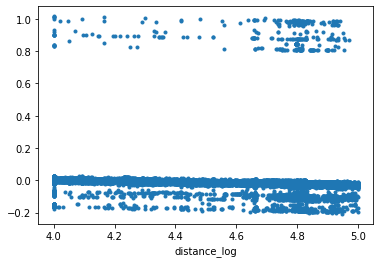

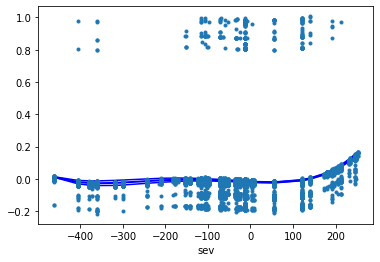

In [392]:
'''
documentação
https://www.statsmodels.org/devel/gam.html
'''

# Aplicar statsmodel
# importe as bibliotecas necessárias
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
# from statsmodels.gam.tests.test_penalized import df_autos

# definir os splines para o modelo dentro do dataset
# x_spline = df_autos[['weight', 'hp']]
x_spline = df[['distance_log', 'sev']]

'''
instancie a classe, passando:
- os dados
- graus de liberdade
- grau do spline
'''
# bs= BSplines(x_spline, df=[12, 10], degree=[3,3])
bs= BSplines(x_spline, df=[3, 5], degree=[2, 4])

# definir penalização, onde o comprimento da lista deve ser igual ao numero de termos regulares no smoother
alpha = np.array([21833888.8, 6460.38479])
# alpha = np.array([cnsultar no trabalho])

'''
crie  o modelo a partir de uma fórmula e dataframe, passando:
- formula que especifica o modelo
- dados do modelo
- a instancia da classe
- a penalidade do modelo, onde o comprimento deve ser igual ao smoother
'''
# gam_bs = GLMGam.from_formula('city_mpg ~ fuel + drive', data=df_autos, smoother=bs, alpha=alpha)
gam_bs = GLMGam.from_formula('flood ~ distance_log + sev', data=df, smoother=bs, alpha=alpha)

# estimar parãmetros e criar uma instancia da classe GLMGamResults
res_bs = gam_bs.fit()

# plotar as estimativas do modelo
res_bs.plot_partial(0, cpr=True)
res_bs.plot_partial(1, cpr=True)

# alpha = np.array([8283989284.5829611, 14628207.58927821])

# gam_bs = GLMGam.from_formula('city_mpg ~fuel + drive', data = df_autos, smoother=bs, alpha=alpha, family=sm.families.Poisson())

# res_bs = gam_bs.fit()

# res_bs.plot_partial(0, cpr=True)

# res_bs.plot_partial(1, cpr=True)

# gam_bs.select_penweight()[0]

# gam_bs.select_penweight_kfold()[0]

res_bs.summary()

### PyGAM

In [ ]:
''' Documentação 
https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Fit-a-Model
Olhar artigos:
https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f
e depois
https://medium.com/just-another-data-scientist/building-interpretable-models-with-generalized-additive-models-in-python-c4404eaf5515
'''
# Teste PyGAM
!pip install pygam

In [393]:
import pandas as pd        
from pygam import LogisticGAM
from sklearn.datasets import load_breast_cancer
#load the breast cancer data set
data = load_breast_cancer()
#keep first 6 features only
df = pd.DataFrame(data.data, columns=data.feature_names)[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
target_df = pd.Series(data.target)
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400


In [394]:
X = df[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
y = target_df
#Fit a model with the default parameters
gam = LogisticGAM().fit(X, y)

In [395]:
gam.accuracy(X, y)

0.9560632688927944

In [406]:
import matplotlib.pyplot as plt

for i, term in enumerate(gam.terms):
  if term.isintercept:
    continue

XX = gam.generate_X_grid(term=i)
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(data.feature_names[0:6]))
titles = data.feature_names
for i, ax in enumerate(axs):
    pdep, confi = gam.partial_dependence(XX, feature=i+1, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
    ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
    ax.set_title(titles[i])
plt.show()

ValueError: ignored

In [405]:
lambda_ = 0.6
n_splines = [25, 6, 25, 25, 6, 4] 
constraints = None
gam = LogisticGAM(constraints=constraints, 
          lam=lambda_,
         n_splines=n_splines).fit(X, y)

In [407]:
gam = LogisticGAM().gridsearch(X, y)

TypeError: ignored

In [408]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
gam = LogisticGAM().gridsearch(X_train, y_train)

TypeError: ignored

In [409]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
predictions = gam.predict(X_test)
print("Accuracy: {} ".format(accuracy_score(y_test, predictions)))
probas = gam.predict_proba(X_test)      
print("Log Loss: {} ".format(log_loss(y_test, probas)))

Accuracy: 0.9574468085106383 
Log Loss: 0.097103438068048 


In [410]:
lambda_ = [0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
n_splines = [4, 14, 4, 6, 12, 12] 
constraints = [None, None, None, None, None, None]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
gam = LogisticGAM(constraints=constraints, 
                  lam=lambda_,
                 n_splines=n_splines).train(X_train, y_train)
predictions = gam.predict(X_test)
print("Accuracy: {} ".format(accuracy_score(y_test, predictions)))
probas = gam.predict_proba(X_test)      
print("Log Loss: {} ".format(log_loss(y_test, probas)))

AttributeError: ignored

In [411]:
from sklearn.datasets import load_boston
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
target_df = pd.Series(boston.target)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [412]:
X = df
y = target_df
gam = LinearGAM(n_splines=10).gridsearch(X, y)
gam.summary()

NameError: ignored

In [413]:
XX = generate_X_grid(gam)
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(boston.feature_names[0:6]))
titles = boston.feature_names
for i, ax in enumerate(axs):
    pdep, confi = gam.partial_dependence(XX, feature=i+1, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
    ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
    ax.set_title(titles[i],fontsize=26)
plt.show()

NameError: ignored

In [ ]:
# verificar os resultados